# Modeling Condenser Water Supply Temperature (CWSHDR) of INSEAD plant with standard regression techniques 

CWSHDR is a timeseries and seasonal patterns can be observed looking at the data. However, the proposition is that Chiller Plants ideally follow the principles of theromodynamics and as such the the parameters logged by sensors demonstrate linear or non-linear relationship. During a certain time period where seasonal patterns are irrelevant, standard regressions model might be able to capture the physical properties of this thermodynamic system.

## A quick look into the data

The below plots represent data from INSEAD Chiller Plant recorded on 17th May, 2017. Some zeros / null values may have been ignored to highlight the big-picture. These plots have been generated using Tableau.

### CWSHDR vs. Time (hours)

You would notice that as the day progresses, there is an increase in CWSHDR value and again reducing the next day begins. This trend can be noticed in the entire dataset and other chiller plants as well. Perhaps, this behavior can be attributed to "business hours" of the buildings.

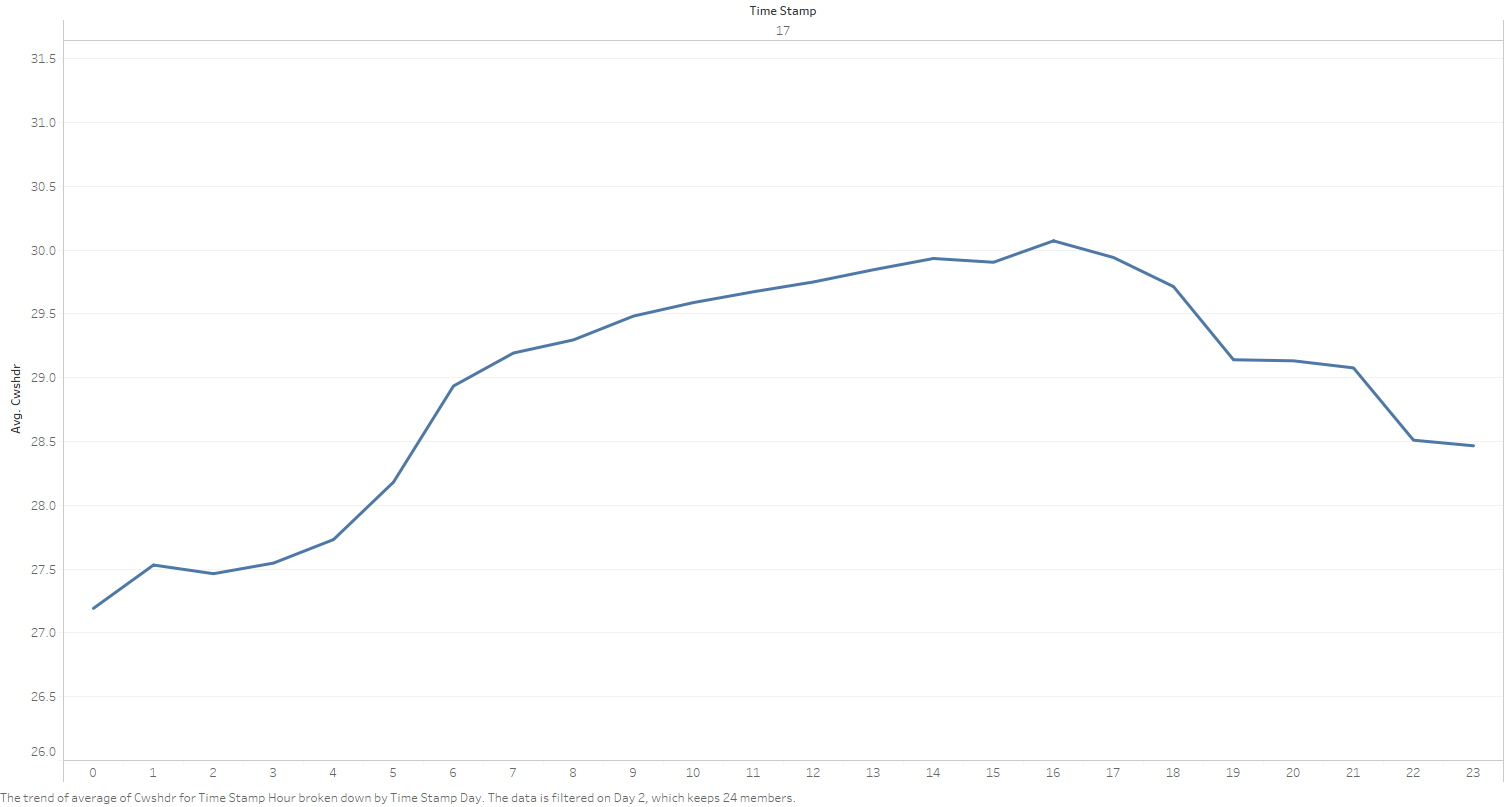

### CWSHDR vs. Drybulb.

1. Each color represents an hour (0-23) of 24 hours. Notice that data points of each hour can be grouped as a cluster! 
2. You could generally notice a up-ward increase of CWSHDR as Drybulb value increases

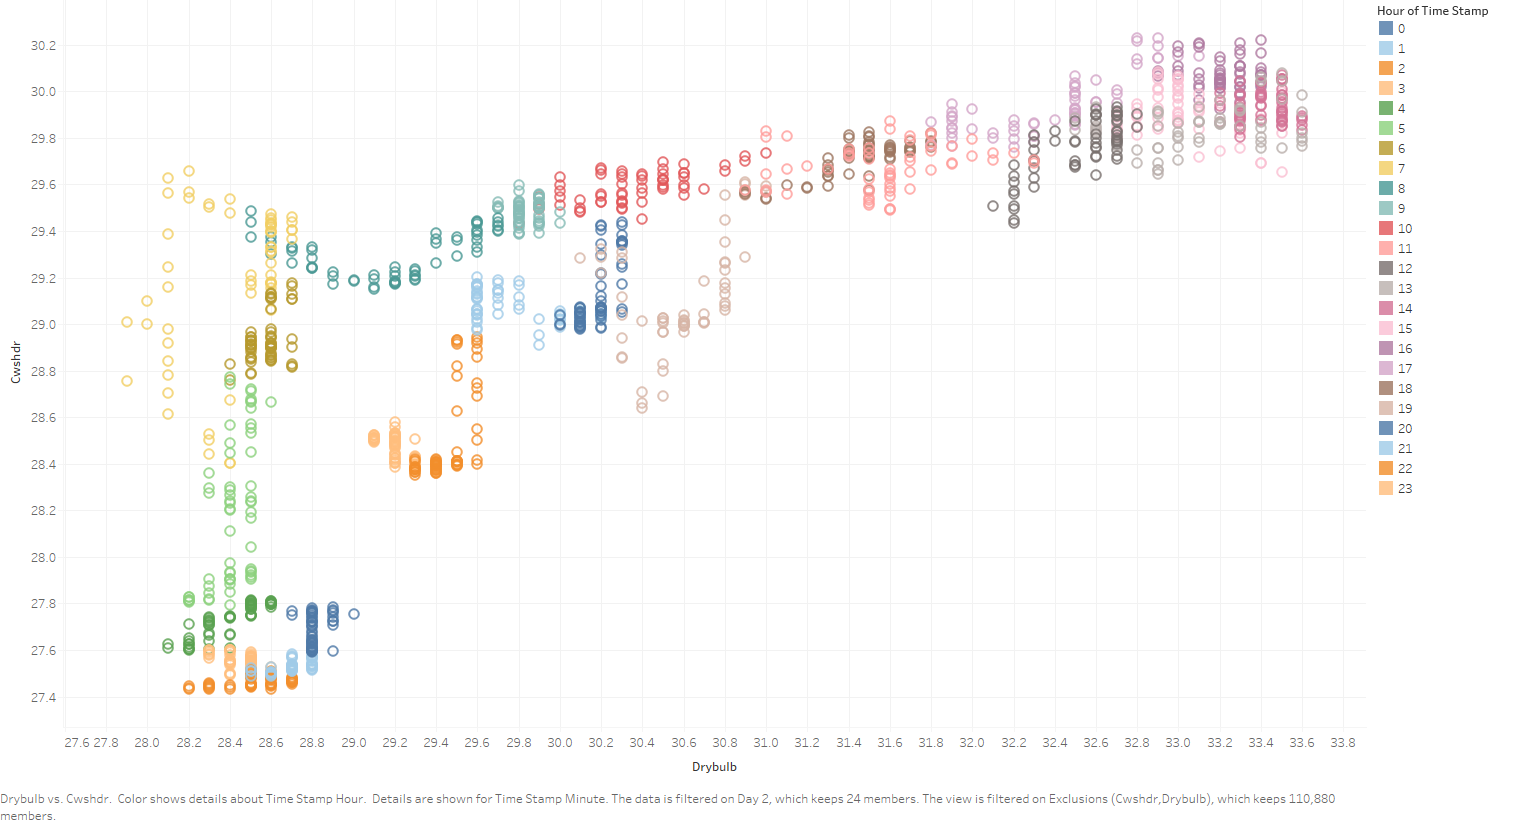

Let's look at the **entire data set (approx 8 months)**. Does the above listed charactersitcs satisfy? Well, yes indeed! 
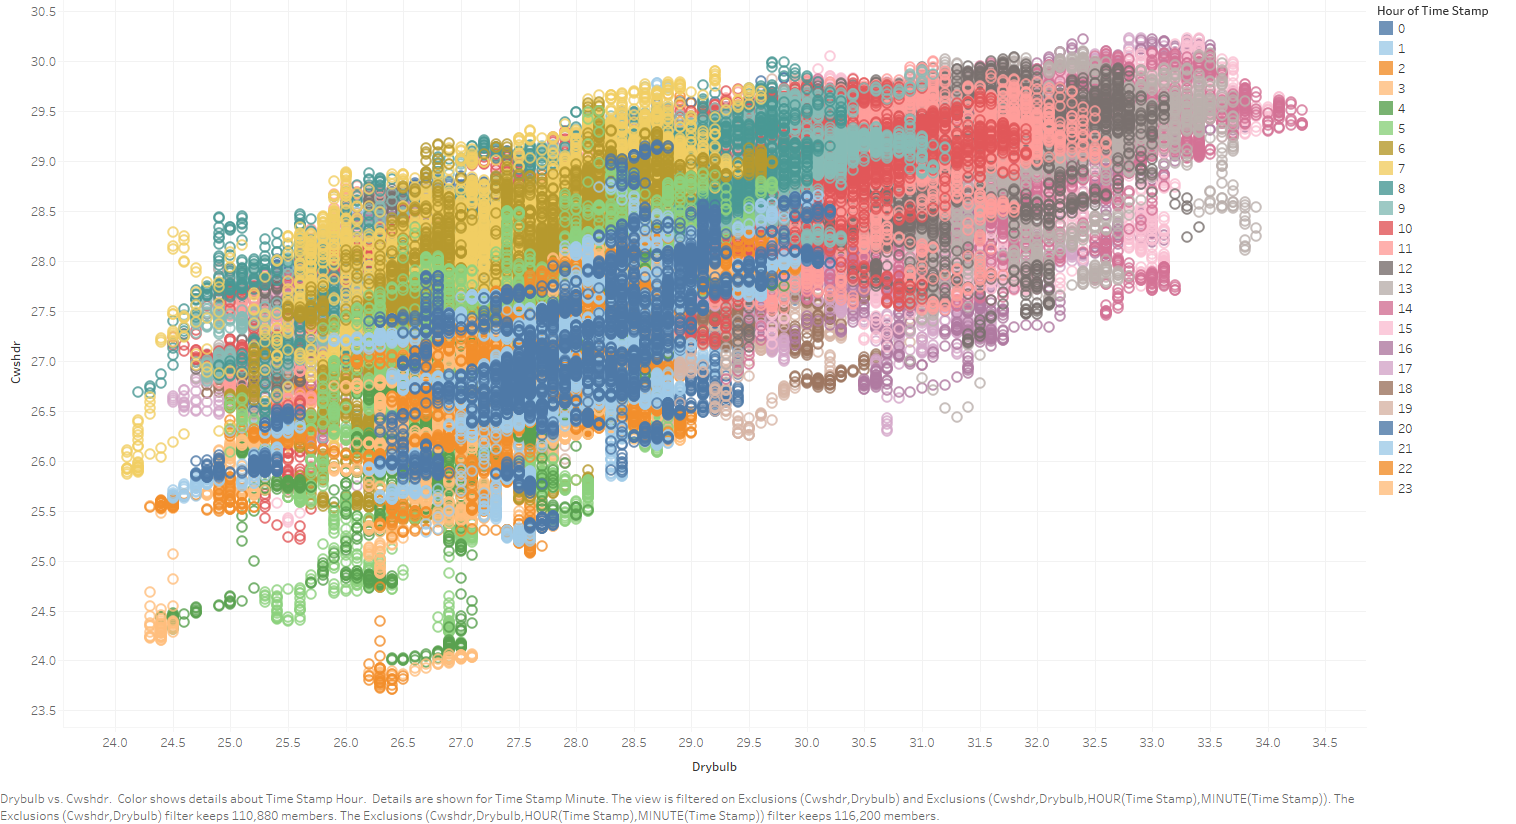

### CWSHDR vs. Rh

There is an downward trend with relative humidity while we observe an upward trend with Drybulb.

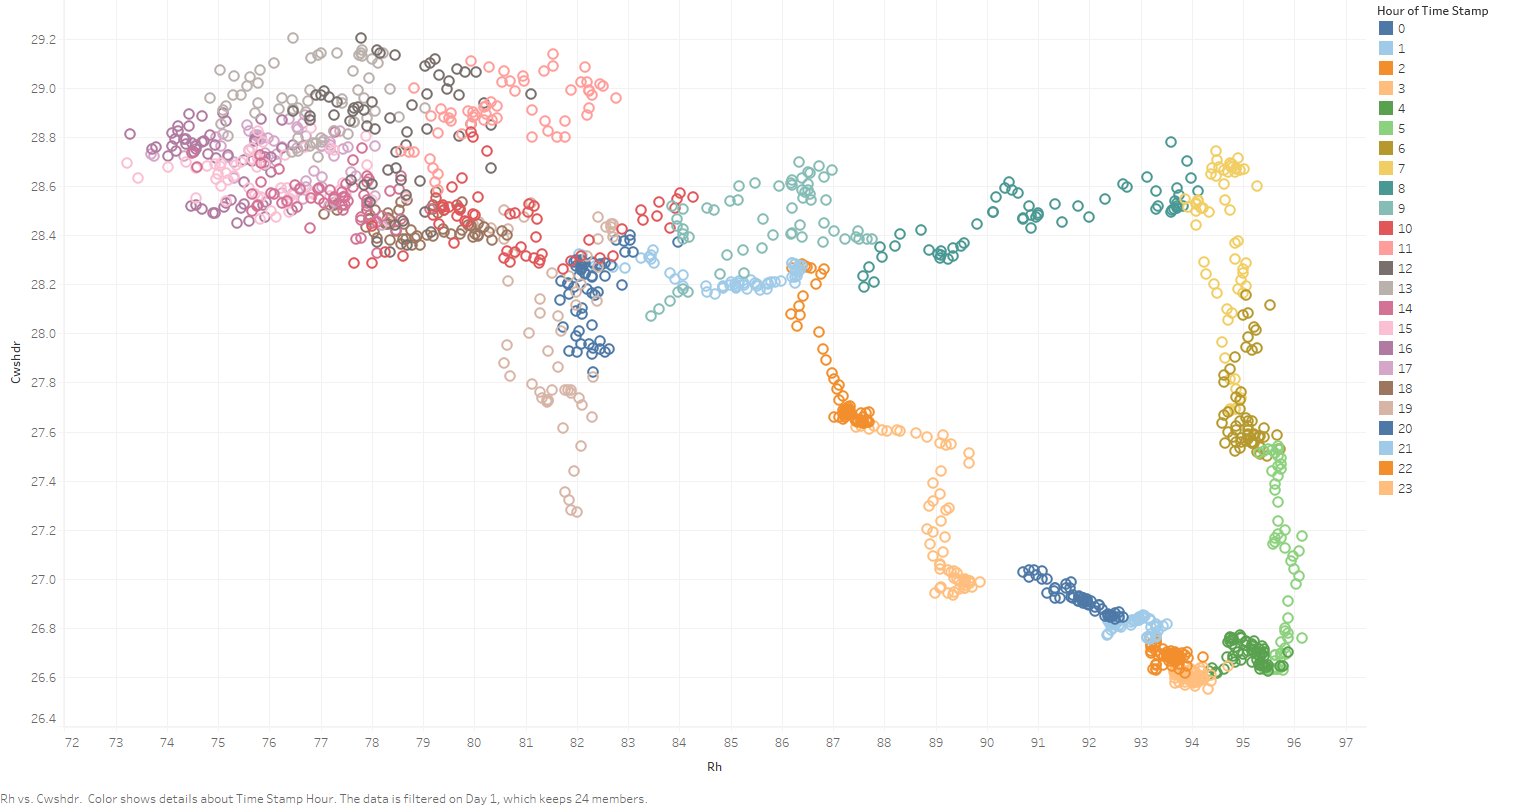

### CWSHDR vs. Loadsys

Coming back to the initial sample (one day data), we can notice an upward trend

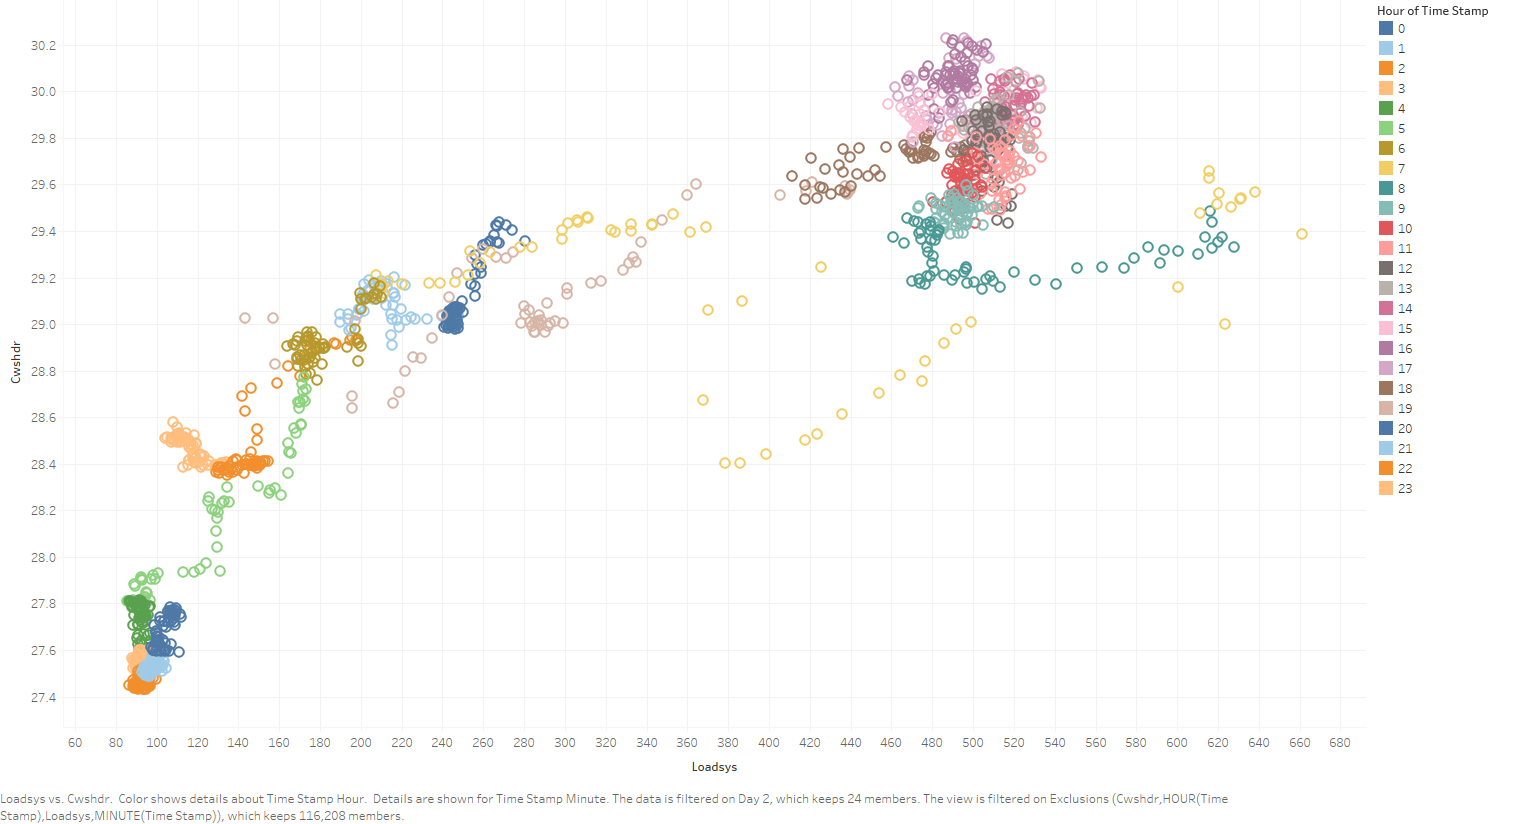

### CWSHDR vs. (CT1KW, CT2AKW)

I don't immediately read any observations that would help in modeling. However, its noticeable that one of the cooling tower is working while the other is shutdown (0KW power). This could be used in regression modeling. My assumptions is that each cooling tower may respond to its Inputs differently. Let's keep this in mind and take a look into how the regression's accuracy changes when the optimizer is given which cooling tower is working.. 

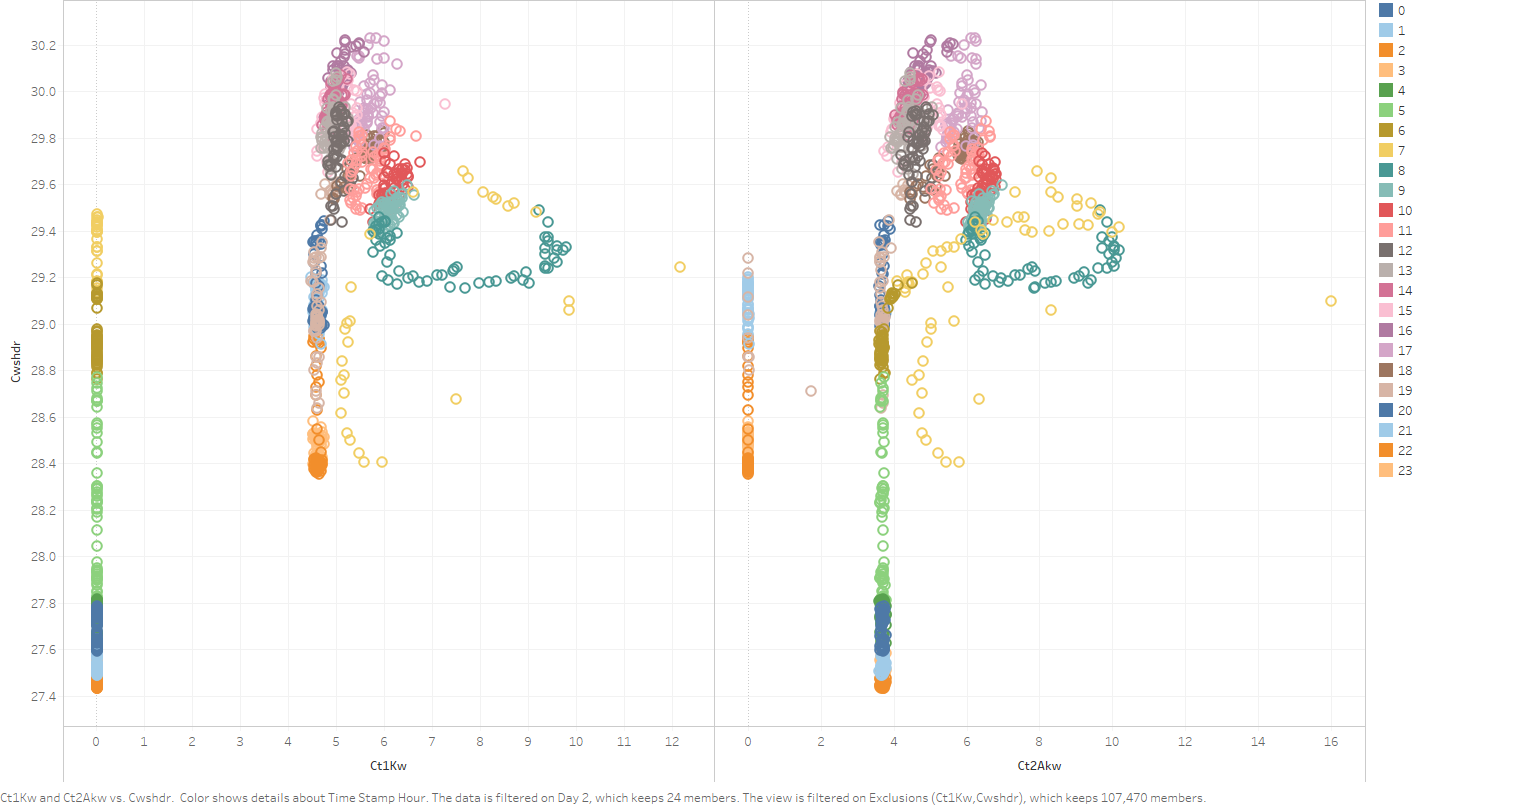

## Load data

Note: My hunch is that Decision Tree would be able to capture the Hour vs. {CWSHDR, Drybulb, Rh, CTKW} properties. So, an ensemble model could improve the accuracy.. Anyway, let's experiment these stuff. But before, let's load the data!!

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np
import glob
import os

In [5]:
# load all csv files of North-point site. Concatenate them..
data_src = "../data"
all_files = glob.glob(os.path.join(data_src, "insead", "*.csv"))
df = pd.concat([pd.read_csv(f, low_memory=False) for f in all_files], ignore_index=True)

# minor changes
df = df.rename(columns={"Time Stamp": "timestamp"})
df = df.replace("\\N", np.nan)

# update data types. object is taken as default
dtypes = dict([(col, np.float64) for col in df.columns])
dtypes["timestamp"] = "datetime64[ns]"
df = df.astype(dtypes)

# change the index to timestamp.
df.index = df.timestamp

In [7]:
# Percentage of null values..
(df.count() * 100)  / df["timestamp"].count()

timestamp      100.000000
chwrhdr        100.000000
chwshdr        100.000000
chwsfhdr       100.000000
cwshdr         100.000000
cwrhdr         100.000000
cwsfhdr        100.000000
ch1kw          100.000000
ch2kw          100.000000
ch3kw          100.000000
chwp1kw        100.000000
chwp2kw        100.000000
chwp3kw        100.000000
chwp4kw         99.978185
cwp1kw         100.000000
cwp2kw         100.000000
cwp3kw          99.501368
ct1kw          100.000000
ct2akw          99.989958
incomingkw1     99.978185
incomingkw2     99.978185
rh              99.978877
drybulb         99.978877
chiller_eff    100.000000
cwp_eff        100.000000
chwp_eff       100.000000
ct_eff         100.000000
chwgpmrt       100.000000
cwgpmrt        100.000000
systotpower    100.000000
loadsys        100.000000
effsys         100.000000
hbsys          100.000000
dtype: float64

You'd notice above there are some null values in the columns we are interested. i.e, Drybulb, Rh, Ct2akw. But there are not too many. So, I'll drop respective data points from the dataset. Anyway, were not viewing this data as timeseries.

In [89]:
# Select the interested features and normalize the data
from sklearn import preprocessing

data = df[ ["cwshdr", "loadsys", "drybulb", "ct1kw", "ct2akw", "rh"] ].dropna()
columns = data.columns
index = data.index.values

scaler = preprocessing.MinMaxScaler()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns=columns, index=index)

## Training the regression models

In [90]:
# preparing some extra features.
data["hour"] = data.index.hour
data["minute"] = data.index.minute
data["minute_sqr"] = data.index.minute ** 2
data["hour_sqr"] = data.index.hour ** 2

# take the sample we're interested in.
train = data["2017-05-17":"2017-05-17"]
test = data["2017-05-18":"2017-05-18"]
validate = data["2017-05-19":"2017-05-19"]

# consider the target and features for training
features = ["loadsys", "drybulb", "ct1kw", "ct2akw", "rh", "hour", "minute", "minute_sqr", "hour_sqr"]
target = "cwshdr"

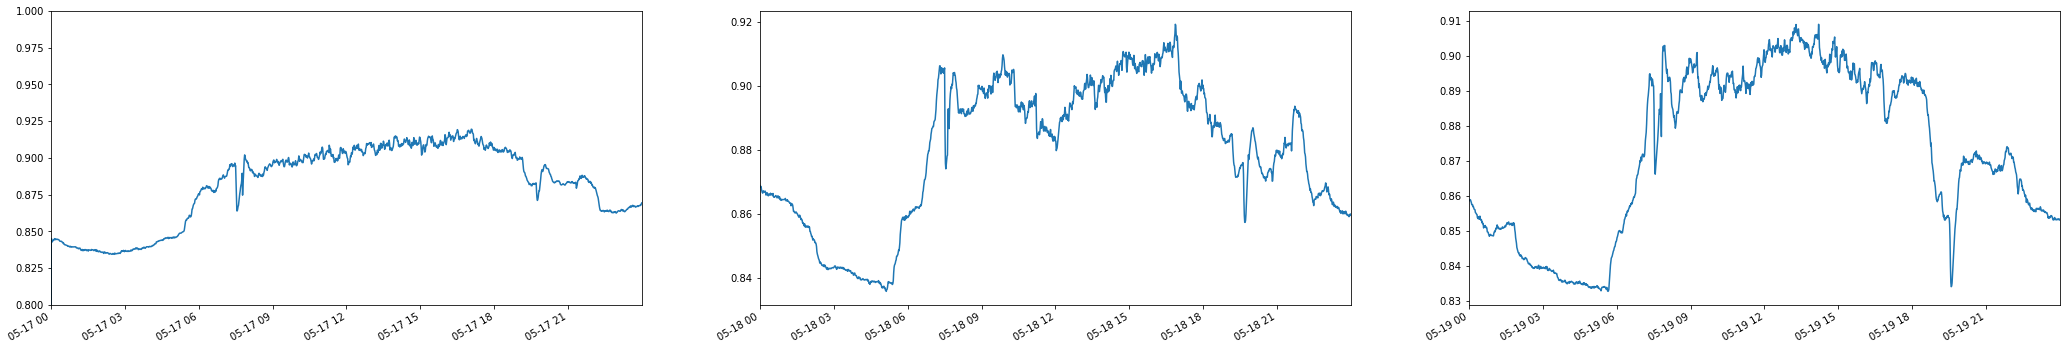

In [91]:
# let's see how the train, test and validation samples of cwshdr
fig, (a1, a2, a3) = plt.subplots(1,3, figsize=(36,6))
train.cwshdr.plot(ax=a1); a1.set_ylim(0.8,1)
test.cwshdr.plot(ax=a2)
validate.cwshdr.plot(ax=a3)

In [92]:
from sklearn import linear_model
from sklearn import metrics 

# fit the model
reg = linear_model.LinearRegression()
reg.fit(train[features].values, train[target].values)

# check the metrics
y_predict = reg.predict(test[features].values)
y_test = test[target].values
mse = metrics.mean_squared_error(y_test, y_predict)
print("MSE: ", mse)

MSE:  0.000173871196207


## Plot the prediction

(0.8, 0.93)

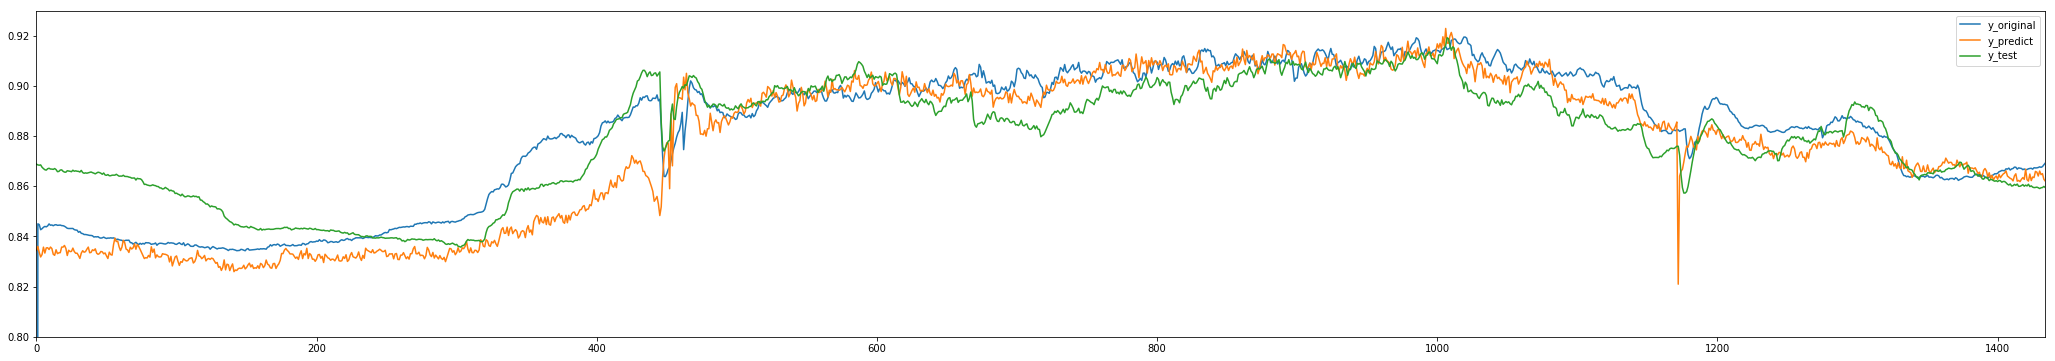

In [93]:
df_plot = pd.DataFrame({"y_test": y_test, "y_predict": y_predict, "y_original": train[target].values})
fig, ax = plt.subplots(1, 1, figsize=(36,6))
df_plot.plot(ax=ax)
ax.set_ylim(0.8, 0.93)

**Not bad for a simple linear regression**